# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms. In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

## Loading the data
As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of 0.2

In [111]:
import pandas as pd
import numpy as np
import pickle
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from joblib import load

In [9]:
df = pd.read_csv('Reviews.csv')

In [10]:
# from google.colab import drive
# drive.mount("/content/drive")

In [11]:
# df = pd.read_csv('/content/drive/My Drive/James老师备课/James/Lecture 2 - Introduction to R _ HW/Reviews.csv')

In [12]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
df.shape # data shape

(568454, 10)

In [14]:
df.nunique() # check num of unique items per column

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218415
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [15]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [16]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [18]:
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")
df.head(5)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [19]:
# check some statistics
print(df['Sentiment'].value_counts())

Sentiment
positive    443777
negative    124677
Name: count, dtype: int64


Select subcolumns

In [21]:
df = df[["Score", "Sentiment", "Summary", "Text"]]

Let's have a look at some 5s:

In [23]:
df[df.Score == 5].head(10)

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...
6,5,positive,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,positive,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,positive,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,positive,Healthy Dog Food,This is a very healthy dog food. Good for thei...
10,5,positive,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
11,5,positive,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
14,5,positive,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,5,positive,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


And some 1s as well:

In [25]:
df[df.Score == 1].head(10)

,Score,Sentiment,Summary,Text
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,negative,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,negative,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,negative,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,negative,stale product.,Arrived in 6 days and were so stale i could no...
73,1,negative,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
75,1,negative,No Tea Flavor,No tea flavor at all. Just whole brunch of art...
99,1,negative,Bad,I fed this to my Golden Retriever and he hated...
153,1,negative,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
164,1,negative,Tasteless but low calorie,Seriously this product was as tasteless as the...


**分割线**（上方是 Data Loading，下方是补充的代码）

---

# Data Cleaning

In [28]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 下载停用词（只需运行一次）
nltk.download('stopwords')

# 初始化工具
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# 文本清洗函数
def clean_text(text):
    # 1. 小写化
    text = text.lower()
    
    # 2. 去除标点符号
    text = ''.join(char for char in text if char not in string.punctuation)
    
    # 3. 分词
    words = text.split()
    
    # 4. 去除停用词 + 词干提取
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]
    
    # 5. 重组为字符串返回
    return ' '.join(cleaned_words)


[nltk_data] Downloading package stopwords to /Users/ricky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
from tqdm import tqdm
tqdm.pandas()  # 启用 pandas 进度条
df['CleanText'] = df['Text'].progress_apply(clean_text)

100%|█████████████████████████████████| 568454/568454 [04:57<00:00, 1911.39it/s]


In [38]:
df.to_csv("cleaned_data.csv", index=False)
# df = pd.read_csv('cleaned_data.csv')
# df

# Feature Engineering

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 初始化向量器（同时考虑 unigram 和 bigram）
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

# 拟合并转换
X = vectorizer.fit_transform(df['CleanText'])

# 保存 TF-IDF 稀疏矩阵（.pkl 格式）
joblib.dump(X, "X_tfidf.pkl")

['X_tfidf.pkl']

In [49]:
print(X.shape)

(568454, 10000)


## Train-Test Splitting

应该在处理imbalance之前，防止information leakage。Test set分完之后就不要动了。

In [62]:
# 标签变量：将 positive/negative 映射为 1/0
y = df['Sentiment'].map({'positive': 1, 'negative': 0})

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Dimensional Reduction

In [65]:
from sklearn.decomposition import TruncatedSVD

# 降维器初始化（可调整 n_components，默认设为200）
svd = TruncatedSVD(n_components=1000, random_state=42)

# 对训练集和测试集进行降维处理
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

# 保存降维后的训练集和测试集（NumPy 数组）
joblib.dump(X_train_reduced, "X_train_reduced.pkl")
joblib.dump(X_test_reduced, "X_test_reduced.pkl")

['X_test_reduced.pkl']

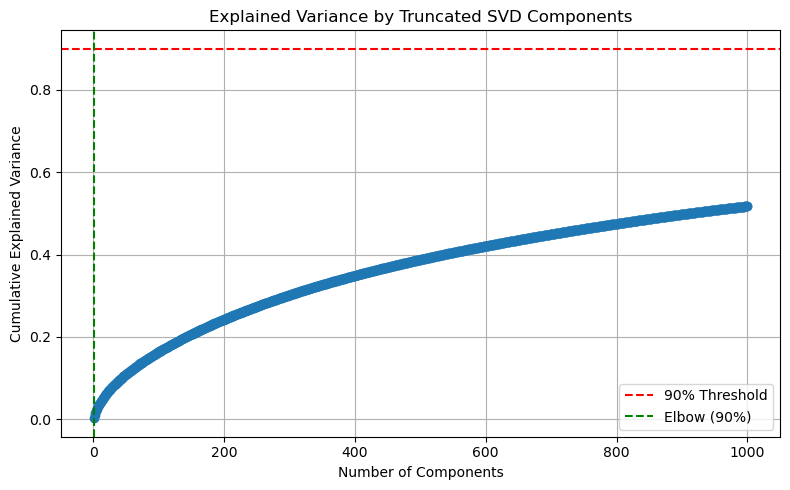

In [145]:
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# 画图
plt.figure(figsize=(8, 5))
plt.plot(range(1, 1001), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Truncated SVD Components')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Threshold')
plt.axvline(x=np.argmax(cumulative_variance >= 0.90) + 1, color='g', linestyle='--', label='Elbow (90%)') #没有找到
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Part 1: Logistic Regression

## Model Building (Baseline)

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 初始化逻辑回归模型
lr_model = LogisticRegression(max_iter=1000)

# 模型训练
lr_model.fit(X_train, y_train)

print("Train Accuracy:", lr_model.score(X_train, y_train))
print("Test Accuracy:", lr_model.score(X_test, y_test))

Train Accuracy: 0.9065051466368196
Test Accuracy: 0.9016896676078142


## Model Evaluation

In [70]:
def evaluate_model(y_true, y_pred, y_prob, title=''):
    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['True Neg', 'True Pos'])
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

    # 分类报告
    print(f"\nClassification Report - {title}:")
    print(classification_report(y_true, y_pred, digits=4))

    # AUC
    auc = roc_auc_score(y_true, y_prob)
    print(f"AUC Score - {title}: {auc:.4f}")

    
    # ROC 曲线
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

我们先看 Sentiment 的分布是否平衡，这是决定选什么指标的关键前提。

In [100]:
df['Sentiment'].value_counts(normalize=True)

Sentiment
positive    0.780674
negative    0.219326
Name: proportion, dtype: float64

该输出显示正面评论占比为 78.07%，负面评论仅占 21.93%，存在显著的类别不平衡问题，后续模型评估应优先采用 Precision、Recall、F1 分数、AUC等指标，而非简单的准确率（Accuracy）。

在本任务中，我们的目标是通过分析用户评论的文本内容，预测其对商品的满意度（正面或负面）。从业务角度来看，误将负面评论预测为正面的后果更为严重，因为这会导致企业无法及时发现和改进产品问题。相比之下，误判正面为负面的影响相对较小。因此，在模型评估中，我们应特别关注对负面类别的 Recall 和 Precision：Recall 衡量模型是否能够识别出所有真正不满意的用户，而 Precision 则反映被预测为不满意的用户中有多少是真正的不满意。这两个指标对于保障客户反馈系统的可靠性至关重要。

下面是逻辑回归基线模型的表现。

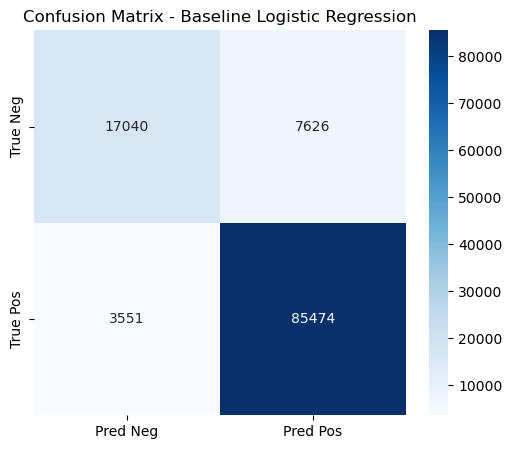


Classification Report - Baseline Logistic Regression:
              precision    recall  f1-score   support

           0     0.8275    0.6908    0.7530     24666
           1     0.9181    0.9601    0.9386     89025

    accuracy                         0.9017    113691
   macro avg     0.8728    0.8255    0.8458    113691
weighted avg     0.8984    0.9017    0.8984    113691

AUC Score - Baseline Logistic Regression: 0.9429


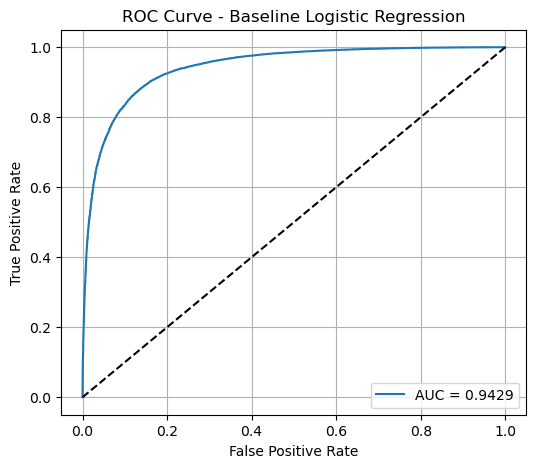

In [103]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# 模型预测
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]  # 预测为正类的概率

evaluate_model(y_test, y_pred, y_prob, title='Baseline Logistic Regression')

尽管该 Logistic 回归模型在整体准确率（90.17%）和 AUC（0.9429）上表现良好，但其对负面评论（不满意用户）的识别效果存在明显不足，负类 recall 仅为 69.08%，意味着模型漏掉了大量真正的不满意用户。考虑到本任务的业务目标是及时发现负面反馈，该模型在实际部署中风险较高，需要进一步优化以提升负类召回率（Recall），例如调整分类阈值、引入类别权重、SMOTE、over/undersampling或使用更复杂模型提升负类识别能力。

## Label Balancing

### 方案一：类别权重

类别权重方法通过在模型训练时为每个类别分配不同的权重，来应对样本分布不平衡的问题，直接作用于模型的损失函数。具体而言，权重按照“样本少的类别赋予更高权重，样本多的类别赋予较低权重”的原则自动计算，使每个类别在损失函数中具有相对均衡的影响力。这样，模型在优化时会更加关注少数类，从而提升其识别能力，尤其有助于提高少数类的召回率（Recall），避免模型过度偏向主流类别的预测。

In [40]:
# 训练加权后的逻辑回归模型
lr_model_bal = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model_bal.fit(X_train, y_train)

# 使用新模型进行预测
y_pred_bal = lr_model_bal.predict(X_test)
y_prob_bal = lr_model_bal.predict_proba(X_test)[:, 1]

# 评估结果
print("Classification Report (positive=1, negative=0):")
print(classification_report(y_test, y_pred_bal, digits=4))

auc = roc_auc_score(y_test, y_prob_bal)
print(f"AUC Score: {auc:.4f}")

Classification Report (positive=1, negative=0):
              precision    recall  f1-score   support

           0     0.6609    0.8720    0.7519     24666
           1     0.9611    0.8761    0.9166     89025

    accuracy                         0.8752    113691
   macro avg     0.8110    0.8740    0.8343    113691
weighted avg     0.8960    0.8752    0.8809    113691

AUC Score: 0.9443


引入 `class_weight='balanced'` 后，模型在识别负面评论方面取得了显著提升，负类 Recall 从原先的 0.6908 提高到 0.8720，大幅减少了漏判不满意用户的风险。虽然 Precision 略有下降，但整体 F1-score 和 AUC 分数依然保持较高水平。该策略有效地缓解了类别不平衡对模型性能的影响，达到了业务上“优先发现负面反馈”的目标。

### 方案二：SMOTE 上采样

在本节中，我们采用了 TruncatedSVD 降维和 SMOTE 上采样的组合策略，以应对文本特征维度高和类别不平衡的问题。TruncatedSVD 是一种适用于稀疏矩阵的线性降维方法，通过保留最重要的主成分，将原始高维的 TF-IDF 向量压缩为较低维度的语义表示，从而提高计算效率并缓解维度灾难。随后，SMOTE（Synthetic Minority Over-sampling Technique）通过在特征空间中对少数类样本进行线性插值，生成合成样本，从而提升模型对少数类的学习能力。

In [43]:
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE

# 1. 降维：适用于稀疏矩阵
svd = TruncatedSVD(n_components=1000, random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

# 2. 上采样（SMOTE）
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced, y_train)

# 3. 训练逻辑回归模型
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_smote, y_train_smote)

# 4. 模型预测与评估
y_pred_smote = lr_model.predict(X_test_reduced)
y_prob_smote = lr_model.predict_proba(X_test_reduced)[:, 1]

print("Classification Report (positive=1, negative=0):")
print(classification_report(y_test, y_pred_smote, digits=4))

auc = roc_auc_score(y_test, y_prob_smote)
print(f"AUC Score: {auc:.4f}")

Classification Report (positive=1, negative=0):
              precision    recall  f1-score   support

           0     0.6127    0.8184    0.7008     24666
           1     0.9445    0.8567    0.8985     89025

    accuracy                         0.8484    113691
   macro avg     0.7786    0.8375    0.7996    113691
weighted avg     0.8725    0.8484    0.8556    113691

AUC Score: 0.9163


在引入 TruncatedSVD 降维和 SMOTE 上采样后，模型在负类（不满意用户）上的召回率显著提升，从之前的 0.69 上升至 0.82，有效缓解了类别不平衡带来的漏判问题。然而，这种提升是以负类 precision 的明显下降为代价（从 0.83 降至 0.61），说明模型虽然能找出更多负面评论，但同时也引入了较多误报。正类预测保持良好，precision 高达 0.94，说明整体判别能力未受明显影响。综合指标来看，模型准确率为 84.84%，AUC 达到 0.9163，具备较强的区分能力。整体而言，该策略在提升负类识别能力方面有效，但在实际部署中需权衡误报带来的业务影响。

### 方案三：随机下采样

随机下采样（Random Under-sampling）是一种通过减少多数类样本数量来实现类别平衡的策略。在训练阶段，它会随机丢弃一部分多数类（如正类）样本，使其数量与少数类（如负类）相等，从而避免模型过度偏向多数类。这种方法简单高效，尤其适用于数据量充足的场景，可以帮助模型更公平地学习两个类别的特征。

In [46]:
from imblearn.under_sampling import RandomUnderSampler

# 使用随机下采样对训练集平衡化
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# 训练逻辑回归模型
lr_rus = LogisticRegression(max_iter=1000)
lr_rus.fit(X_rus, y_rus)

# 模型预测
y_pred_rus = lr_rus.predict(X_test)
y_prob_rus = lr_rus.predict_proba(X_test)[:, 1]

print("Classification Report (positive=1, negative=0):")
print(classification_report(y_test, y_pred_rus, digits=4))

auc = roc_auc_score(y_test, y_prob_rus)
print(f"AUC Score: {auc:.4f}")

Classification Report (positive=1, negative=0):
              precision    recall  f1-score   support

           0     0.6479    0.8726    0.7437     24666
           1     0.9610    0.8686    0.9125     89025

    accuracy                         0.8695    113691
   macro avg     0.8044    0.8706    0.8281    113691
weighted avg     0.8930    0.8695    0.8758    113691

AUC Score: 0.9413


从结果来看，模型在负类（0）上的 recall 达到 0.8726，表明大多数负面评论已被成功识别，符合我们业务上“优先发现不满意用户”的目标。虽然负类的 precision 下降至 0.6479，说明有部分正类被误判为负类，但这种误判对业务影响相对较小，因为预测为负面会触发关注、补救等措施，即使错把满意用户当作不满意，也只是“多关心了用户”，风险较低。相比之下，漏判负面用户的后果更严重，因此当前模型在 recall 优先的目标下表现较为理想。此外，整体 accuracy 为 86.95%，AUC 为 0.9413，说明模型整体区分能力依然强。

## Regularization

### Hyperparameter Tuning (l1 ratio)

在前面最好的模型（Balanced logistic regression，即带有类别权重的逻辑回归）的设置下进行正则化的超参数调优。

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

# 设置超参数搜索空间
param_grid = {
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# 创建逻辑回归模型
base_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# 定义评分函数：负类 recall
recall_neg_scorer = make_scorer(recall_score, pos_label=0)

# 构建 GridSearchCV (3-fold cross validation)
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=recall_neg_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# 开始训练（方案一：X_train, y_train；方案三：X_rus, y_rus）
grid.fit(X_train, y_train)

# 输出最优参数与得分
print(f"\nBest l1_ratio: {grid.best_params_['l1_ratio']}")
print(f"Best mean CV Recall (negative class): {grid.best_score_:.4f}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .......................................l1_ratio=0.1; total time=12.1min
[CV] END .......................................l1_ratio=0.5; total time= 9.7min
[CV] END .......................................l1_ratio=0.7; total time= 8.3min
[CV] END .......................................l1_ratio=0.3; total time=10.1min
[CV] END .......................................l1_ratio=0.7; total time= 8.2min
[CV] END .......................................l1_ratio=0.3; total time=10.2min
[CV] END .......................................l1_ratio=0.7; total time= 8.6min
[CV] END .......................................l1_ratio=0.5; total time= 9.3min
[CV] END .......................................l1_ratio=0.5; total time= 9.6min
[CV] END .......................................l1_ratio=0.1; total time=10.6min
[CV] END .......................................l1_ratio=0.9; total time=11.2min
[CV] END .......................................l

### Best Model (Logistic Regression: Balanced Label Weights + Elastic Net Regularization)

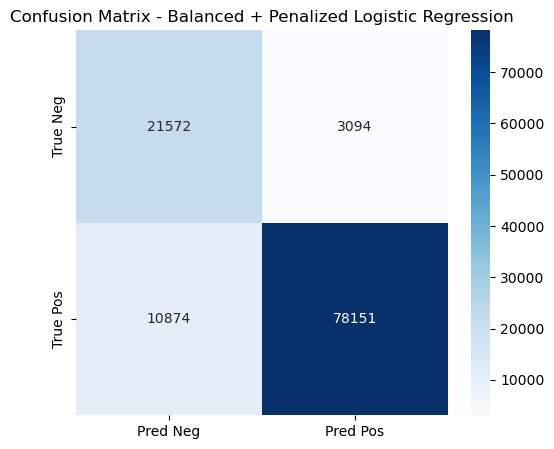


Classification Report - Balanced + Penalized Logistic Regression:
              precision    recall  f1-score   support

           0     0.6649    0.8746    0.7554     24666
           1     0.9619    0.8779    0.9180     89025

    accuracy                         0.8771    113691
   macro avg     0.8134    0.8762    0.8367    113691
weighted avg     0.8975    0.8771    0.8827    113691

AUC Score - Balanced + Penalized Logistic Regression: 0.9452


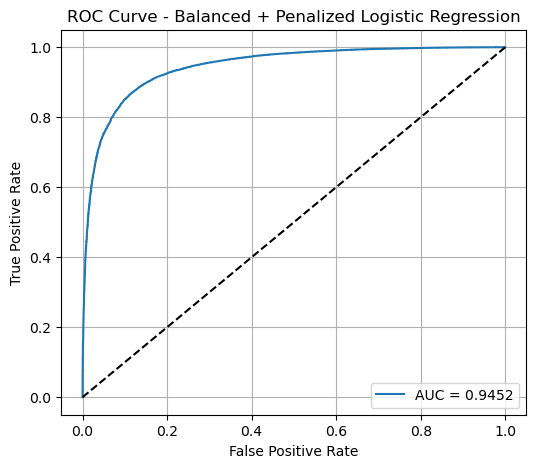

In [120]:
# 从 GridSearchCV 中提取最优模型
best_model = grid.best_estimator_

# 用最佳模型进行预测
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_best, y_prob_best, title='Balanced + Penalized Logistic Regression')

在引入类别权重和正则化并进行超参数调优后，模型在整体表现上更加均衡。尽管测试集的总体准确率略有下降（从 90.17% 降至 87.71%），但负类（label=0）的 recall 从 0.6908 显著提升到 0.8746，f1-score 也从 0.7530 提升到 0.7554，显示模型在检测少数类样本上的能力大幅增强。与此同时，正类（label=1）依然维持了较高的 recall（从 0.9601 仅微幅下降至 0.8779）和 f1-score（从 0.9386 降至 0.9180），表现依然稳健。

虽然加入类别权重后导致负类 precision 从 0.8275 降至 0.6649，出现了较多假阳性，但这是提升 recall 的自然代价。在实际任务中，如若对负类漏判代价较高（例如将负面情绪预测错为正面），优先优化 recall 是合理的策略。因此，precision 的下降是可接受的，尤其在 AUC 提升（从 0.9429 至 0.9452）的背景下，模型区分能力整体提升，验证了该优化策略的有效性。

## Feature Importance

In [113]:
# 获取特征名称（需要在向量器中保留）
feature_names = vectorizer.get_feature_names_out()

# 获取模型系数（注意：shape 是 (1, n_features)，所以要 flatten）
coefficients = best_model.coef_.flatten()

# 构建 DataFrame 排序查看
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# 显示最重要的前20个正系数特征
print("🔼 Top 20 features most associated with positive sentiment:")
print(importance_df.head(20))

# 显示最重要的前20个负系数特征
print("\n🔽 Top 20 features most associated with negative sentiment:")
print(importance_df.tail(20).iloc[::-1])


🔼 Top 20 features most associated with positive sentiment:
               Feature  Coefficient
3614         four star    11.210581
6602           perfect    10.972428
9787   wont disappoint    10.673259
4413  highli recommend    10.652876
2328            delici    10.545870
4113             great     9.729649
3030             excel     9.353800
5392              love     9.290543
796               best     9.155748
9559        wasnt sure     9.119932
4445              hook     8.924489
9664        well worth     8.786550
7895           skeptic     8.732514
394               amaz     8.054673
6013  never disappoint     7.855202
614             awesom     7.289797
1484         cant wait     7.077812
234             addict     7.012712
2946       even better     6.985010
9980               yum     6.964585

🔽 Top 20 features most associated with negative sentiment:
            Feature  Coefficient
8926     three star   -13.064193
9824          worst   -12.374090
9786       wont buy   -10.

## Restore Model

In [125]:
import joblib

# 保存最佳模型
joblib.dump(grid.best_estimator_, 'best_logistic_model.pkl')

# # 载入模型
# restored_model = joblib.load('best_logistic_model.pkl')

['best_logistic_model.pkl']

# Part 2: Random Forest

## Model Building

### 方案一：类别权重

根据Part 1中标签不平衡的问题，我们直接启用按类别权重调整损失函数。对于随机森林，我们直接进行超参数调优。

In [66]:
from sklearn.ensemble import RandomForestClassifier

# 1. 定义随机森林模型（不降维，处理不平衡）
rf = RandomForestClassifier(
    class_weight='balanced',   # 核心参数：自动按类别权重调整
    random_state=42,
    n_jobs=-1                  # 并行训练
)

# 2. 构建参数搜索空间
param_grid = {
    'n_estimators': [100, 300, 500],             # 森林大小
    'max_depth': [10, 20],                  # 每棵树最大深度
    'min_samples_split': [5, 10, 20],            # 节点最小划分样本数
    'min_samples_leaf': [5, 10, 20],             # 最小叶子节点样本数
    'max_features': ['sqrt']        # 每棵树使用的特征数策略
}

# 3. 设定评估指标为 recall (负类)
recall_neg_scorer = make_scorer(recall_score, pos_label=0)

# 4. 构建 GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=recall_neg_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

# 5. 训练模型（X_train 来自 TF-IDF；y_train 为二元标签 0/1）
grid_rf.fit(X_train, y_train)

# 6. 输出最优参数
print("\nBest Parameters:")
print(grid_rf.best_params_)
print(f"Best CV Recall (negative class): {grid_rf.best_score_:.4f}")

# 保存调优后的最佳模型
joblib.dump(grid_rf.best_estimator_, "best_rf.pkl")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time= 1.0min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time= 1.6min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time= 1.6min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300; total time= 1.2min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=  27.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=  22.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estima

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time= 1.0min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  22.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  24.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  24.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time= 1.9min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300; total time=  58.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=500; total time= 1.8min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time= 1.3min
[CV] END max_depth=10, max_featur

['best_rf.pkl']

## Model Evaluation

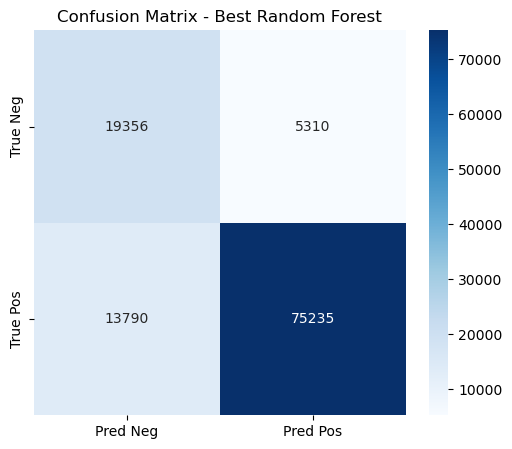


Classification Report - Best Random Forest:
              precision    recall  f1-score   support

           0     0.5840    0.7847    0.6696     24666
           1     0.9341    0.8451    0.8874     89025

    accuracy                         0.8320    113691
   macro avg     0.7590    0.8149    0.7785    113691
weighted avg     0.8581    0.8320    0.8401    113691

AUC Score - Best Random Forest: 0.9022


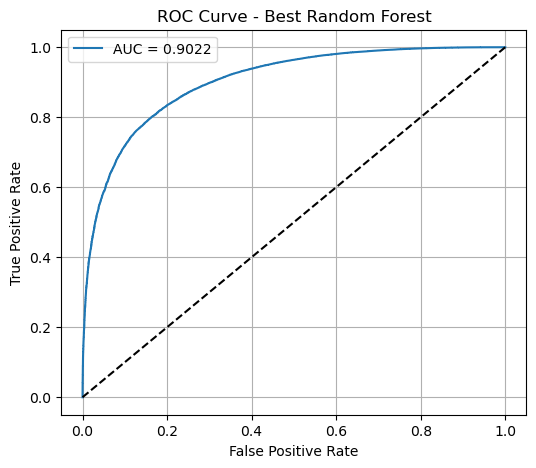

In [80]:
# 获取 GridSearchCV 中最优模型
best_rf_model = grid_rf.best_estimator_

# 预测
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]  # 正类概率（用于 AUC）

# 调用之前定义的 evaluate_model 函数
evaluate_model(y_test, y_pred_rf, y_prob_rf, title='Best Random Forest')


## Feature Importance

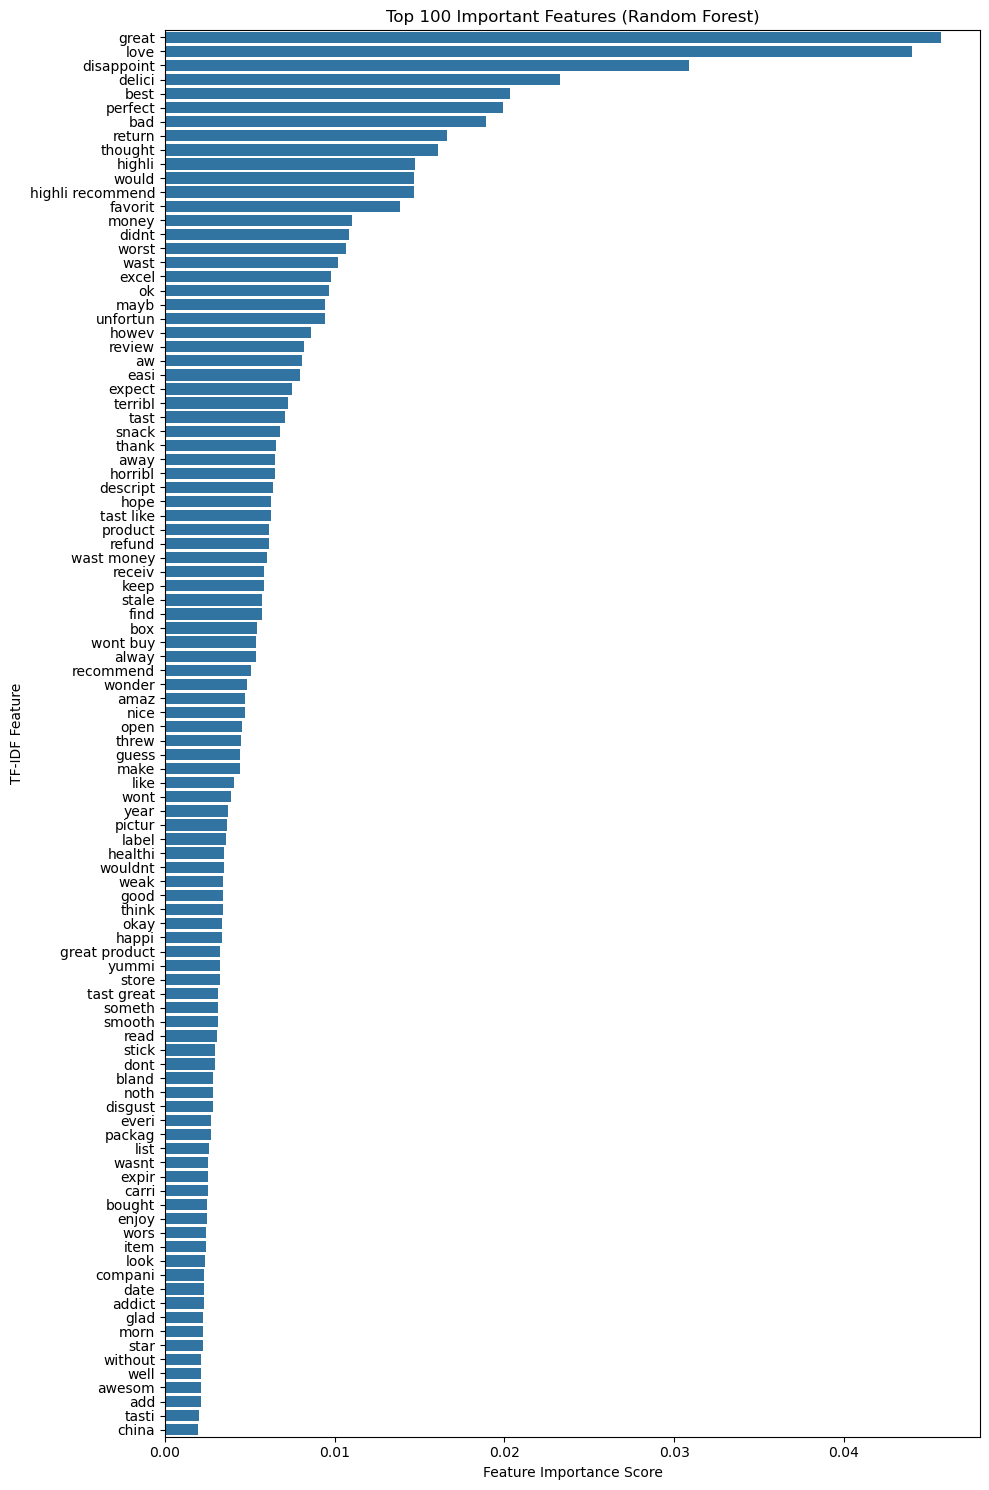

In [134]:
from joblib import load
best_rf = load("best_rf.pkl")

importances = best_rf.feature_importances_

# 获取 TF-IDF 特征名称
feature_names = vectorizer.get_feature_names_out()

# 组成 DataFrame，便于排序与可视化
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 取前30个最重要特征
top_n = 100
top_features = importances_df.head(top_n)

plt.figure(figsize=(10, 15))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Important Features (Random Forest)')
plt.xlabel('Feature Importance Score')
plt.ylabel('TF-IDF Feature')
plt.tight_layout()
plt.show()

在训练并调优带有类别权重平衡的随机森林模型后，我们提取并可视化了前 100 个最重要的 TF-IDF 特征。从图中可以看出，模型识别出的高权重词语包括许多带有明显情感倾向的词，例如正面情绪词 “great”、“love”、“delici”，以及负面情绪词 “disappoint”、“bad”、“return”。这说明模型能够有效捕捉文本评论中的情感极性，并利用这些关键信息进行准确分类。

例如，像 “refund”（退款）、“worst”（最差）和 “waste”（浪费）等词语，很可能是模型识别负类（标签为 0）的主要依据。而词汇 “perfect”、“highli recommend”（强烈推荐）和 “best” 等，则清晰地传达了积极的用户体验，帮助模型判断正类。这些结果不仅印证了模型在指标上的良好表现，也展示了其具备可解释性，能够为后续的业务分析和决策提供有价值的依据。

## Try Dimensional Reduction

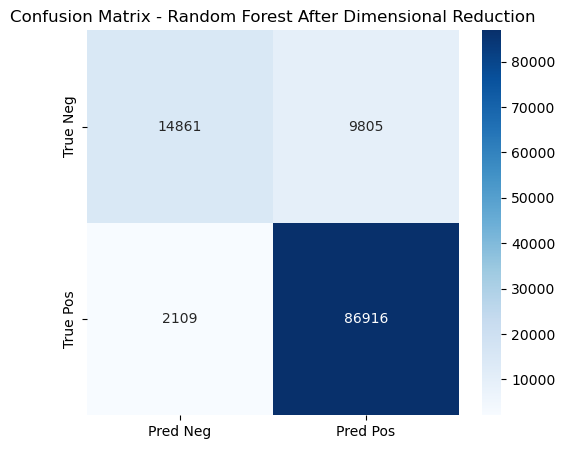


Classification Report - Random Forest After Dimensional Reduction:
              precision    recall  f1-score   support

           0     0.8757    0.6025    0.7139     24666
           1     0.8986    0.9763    0.9359     89025

    accuracy                         0.8952    113691
   macro avg     0.8872    0.7894    0.8249    113691
weighted avg     0.8937    0.8952    0.8877    113691

AUC Score - Random Forest After Dimensional Reduction: 0.9400


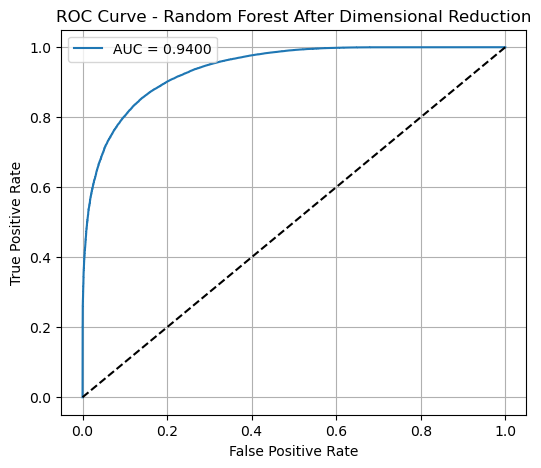

In [82]:
# 使用之前 GridSearch 得到的最佳参数
best_rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_reduced, y_train)

# 模型预测
y_pred = best_rf.predict(X_test_reduced)
y_prob = best_rf.predict_proba(X_test_reduced)[:, 1]

# 评估函数（之前应已定义 evaluate_model）
evaluate_model(y_test, y_pred, y_prob, title="Random Forest After Dimensional Reduction")


可以看到，使用类别权重和降维显著提升了负类precision。接下来，我们尝试其他标签平衡方法。

### 方案二：SMOTE 上采样

In [84]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_reduced, y_train)

# 随机森林训练（使用之前调优过的最佳参数）
rf_smote = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_smote.fit(X_smote, y_smote)

# 预测与评估
y_pred = rf_smote.predict(X_test_reduced)
y_prob = rf_smote.predict_proba(X_test_reduced)[:, 1]

print("Classification Report – Random Forest with SMOTE:")
print(classification_report(y_test, y_pred))
print("AUC Score – Random Forest with SMOTE:", round(roc_auc_score(y_test, y_prob), 4))

Classification Report – Random Forest with SMOTE:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73     24666
           1       0.91      0.95      0.93     89025

    accuracy                           0.89    113691
   macro avg       0.85      0.81      0.83    113691
weighted avg       0.89      0.89      0.89    113691

AUC Score – Random Forest with SMOTE: 0.9369


### 方案三：随机下采样

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# 拟合随机森林
rf_down = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_down.fit(X_rus, y_rus)

# 评估
y_pred_down = rf_down.predict(X_test)
y_proba_down = rf_down.predict_proba(X_test)[:, 1]

print("Classification Report – RF with RUS:")
print(classification_report(y_test, y_pred_down))
print("AUC Score – RF with RUS:", round(roc_auc_score(y_test, y_proba_down), 4))


| 方法         | Recall (negative) | Precision (negative) | F1 (negative) | AUC    | Accuracy |
| ---------- | ----------------- | -------------------- | ------------- | ------ | -------- |
| 类别权重调整（调参后） | 0.7847            | 0.5840               | 0.6696        | 0.9022 | 0.8320   |
| SMOTE      | 0.6700            | 0.7900               | 0.7300        | 0.9369 | 0.8900   |
| 随机下采样      | 0.8000            | 0.5500               | 0.6500        | 0.8950 | 0.8200   |

总的来看，若目标是最大化负类识别（例如负面评论识别、欺诈检测等）：推荐使用随机下采样或类别权重调整并调参后的模型。若目标是整体预测性能的平衡：推荐使用SMOTE 增强后的随机森林模型。

# Part 3: Soft Voting

在本次建模过程中，我们针对高维稀疏的 TF-IDF 特征矩阵，统一采用了 Truncated Singular Value Decomposition（SVD） 方法进行降维处理，将维度从原始的10000个特征压缩至 1000 维。这种方法不仅提升了模型训练的效率，还在一定程度上保留了文本的主要语义结构，减少了过拟合的风险。

在此基础上，我们分别训练了两个性能互补的分类器：使用降维后数据的随机森林模型（带类别权重）在预测负类时表现出较高的 precision（0.8757），表明其对负类判断更为谨慎，但 recall（0.6025） 较低，未能充分识别全部负类；而最开始训练的经过正则化与类别加权的 逻辑回归模型则具有 更高的 recall（0.8746），更擅长覆盖负类，但 precision（0.6649）相对较低。

为充分结合两者优势，我们引入了 软投票（Soft Voting）策略的集成模型，融合两者的预测概率，以期在精度与召回之间取得更优的权衡，提升整体模型在不平衡标签场景下的鲁棒性和判别能力。

**Soft Voting（软投票）** 是一种集成学习方法，常用于**集成多个分类器的预测概率**，以提升模型的整体性能，特别是在不同模型互补时表现优秀。

### 📌 Soft Voting 原理：

* 假设我们有 $N$ 个基分类器（如本项目中的逻辑回归和随机森林）。

* 每个分类器在给定样本 $x$ 上预测出属于每个类别的**概率分布**（而不是直接的类别标签）。

* 对于每个类别 $c$，我们将所有模型预测的该类别的概率取平均（或加权平均）：

  $$
  P_{\text{soft}}(c \mid x) = \frac{1}{N} \sum_{i=1}^{N} P_i(c \mid x)
  $$

  如果加权（Weighted Soft Voting），就是：

  $$
  P_{\text{soft}}(c \mid x) = \sum_{i=1}^{N} w_i \cdot P_i(c \mid x)
  $$

  其中 $w_i$ 是第 $i$ 个模型的权重。

* 最终预测类别为 **具有最高平均概率的类别**：

  $$
  \hat{y} = \arg\max_c P_{\text{soft}}(c \mid x)
  $$


### 💡 本项目中使用 Soft Voting 的意义：

* 逻辑回归对负类 recall 更高 → 能识别更多负类
* 随机森林对负类 precision 更高 → 预测为负类时更可靠
* Soft voting 可以融合两者对负类的不同判断倾向，通过概率加权**取得更优的平衡**

这种方法在**不平衡分类问题中非常常见**，尤其适用于提升少数类的召回能力，同时保持较高的整体准确率。


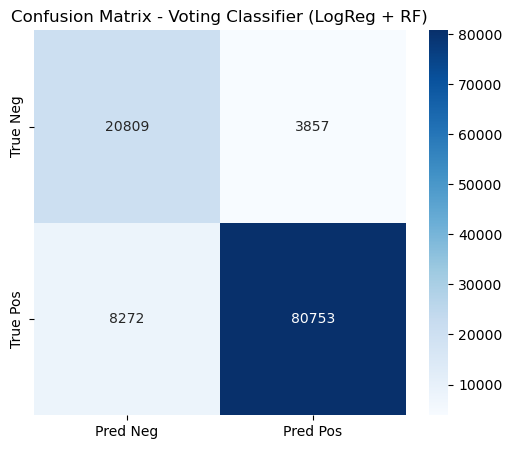


Classification Report - Voting Classifier (LogReg + RF):
              precision    recall  f1-score   support

           0     0.7156    0.8436    0.7743     24666
           1     0.9544    0.9071    0.9301     89025

    accuracy                         0.8933    113691
   macro avg     0.8350    0.8754    0.8522    113691
weighted avg     0.9026    0.8933    0.8963    113691

AUC Score - Voting Classifier (LogReg + RF): 0.9506


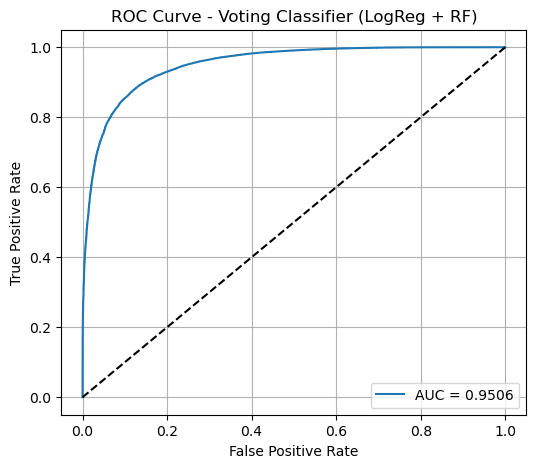

In [101]:
from sklearn.ensemble import VotingClassifier

# 载入已保存的最佳逻辑回归模型
best_log_reg = joblib.load('best_logistic_model.pkl')

# 用前面已经训练好的随机森林模型
best_rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train_reduced, y_train)

# 创建 soft voting 模型（使用 predict_proba）
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', best_log_reg),
        ('rf', best_rf)
    ],
    voting='soft',        # soft voting 使用概率平均
    n_jobs=-1
)

# 训练 voting 模型
voting_clf.fit(X_train_reduced, y_train)

# 预测
y_pred = voting_clf.predict(X_test_reduced)
y_prob = voting_clf.predict_proba(X_test_reduced)[:, 1]

# 评估
evaluate_model(y_test, y_pred, y_prob, title="Voting Classifier (LogReg + RF)")

最终构建的 Soft Voting 模型结合了两类表现各有侧重的分类器 —— 降维后、带类权重的随机森林（对负类 precision 高）与 带正则化的逻辑回归模型（对负类 recall 更优）。Soft Voting 在预测时通过融合两个基模型的预测概率，充分发挥了它们在不同维度上的优势互补。

从评估结果来看，Voting Classifier 在负类（0类）上取得了 precision = 0.7156 和 recall = 0.8436，比逻辑回归单模（recall 高但 precision 较低）和平衡后的随机森林（precision 高但 recall 稍逊）都有所改进，实现了两者的平衡。同时，该模型的 AUC 达到 0.9506，在所有模型中表现最优，说明它在区分正负类方面具有更强的判别能力。

总体而言，Soft Voting 不仅提升了整体预测准确度，也优化了负类（稀有事件）识别能力，是当前任务中最具鲁棒性的模型方案。

## Restore Model

In [105]:
joblib.dump(voting_clf, 'voting_classifier_model.pkl')

['voting_classifier_model.pkl']